# Introduction

Link to the problem [FrozenLake-v0](https://gym.openai.com/envs/FrozenLake-v0/).   
The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile. 

Solve FrozenLake using first principles (just using numpy). The solution must be of the form of a learning algorithm (jupyter notebook) that can learn to reach goal after a series of training exercises.

In [1]:
import numpy as np
import gym
import random
import matplotlib.pyplot as plt
np.random.seed = 29

In [2]:
env = gym.make("FrozenLake-v0")

 `The surface is described using the below grid
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located`

The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.

The actions that the agent can take = `LEFT, DOWN, RIGHT, UP` and the indices that denote these actions are given below  
`LEFT = 0
 DOWN = 1
 RIGHT = 2
 UP = 3`

In [3]:
direction = {0:'LEFT ', 1:'DOWN ', 2:'RIGHT', 3:'UP   '}

## Depicting one attempt
Lets see the game in action by checking out the walking pattern of the agent 

In [4]:
observation = env.reset()
env.render()
for i in range(100):
    observation, reward, done, info = env.step(env.action_space.sample())
    env.render()
    if done: 
        print('{} steps to complete'.format(i+1))
        break
env.close()


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
5 steps to complete


Notice that though the agent is instructed to go in a particular direction, he doesnt necassariy get there due to slipperiness of the ice. 

# Training the Agent

 ## Random walk
 Let us compute the probability that the agent ends up at the 'Goal' if he randomly selects his direction. We could have computed this analytically if the ice werent slippery, i.e., the actions were deterministic. 

In [5]:
n, max_steps = 10000, 100
total_reward = 0
num_steps = []
for episode in range(n):
    observation = env.reset()
    for i in range(max_steps):
        observation, reward, done, info = env.step(env.action_space.sample())
        if done: 
            total_reward += reward
            num_steps.append(i+1)
            break
env.close()
print('Success Percentage = {0:.2f} %'.format(100*total_reward/n))
print('Average number of steps taken to reach the goal = {0:.2f}'.format(np.mean(num_steps)))

Success Percentage = 1.37 %
Average number of steps taken to reach the goal = 7.65


## Training a Q-Table for Slippery Conditions

Q (Quality) - table is a num_state x num_action dimension table that is obtained by training on the map. For each state, it stores values proportional to the reward that can be obtained by taking each of the num_actions actions. In other words, if we were to have a fully trained Q-table, then the optimal action to take when we are in i-th state would be `argmax(qtable[i, :])`. If the action was deterministic, then the any action leading to a hole should store 0, and an action leading to the goal would store a large value.  

Every episode, we update this table by observing the reward that is obtained by taking that step as below

$Q(s, a) = Q(s, a) + \alpha*\left( R(s, a) + \gamma \max_{a'} Q(s', a') - Q(s, a) \right)$

Here 
* Q(s, a) = q-table value for state s and action a
* $\alpha$ = Learning Rate
* R(s, a) = Reward obtained by performing action a from state s
* $\gamma$ = Discount Factor used to balance immediate and future reward
* s' = Destination state from state s and action a
* a' = Maximizing over all the actions from the destination state s'

In [6]:
# Initialize the q-table to all zeros
num_actions = env.action_space.n
num_states = env.observation_space.n
q_table = np.zeros((num_states, num_actions))

In [7]:
# Q-table update parameters
alpha = 0.8
gamma = 0.95

# Exploration paramters
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.001

In [8]:
rewards = []
epsilon = max_epsilon
n, max_steps = 25000, 100
for episode in range(n):
    s = env.reset()
    total_reward = 0
    for i in range(max_steps):
        if random.uniform(0, 1) < epsilon:
            a = env.action_space.sample()
        else:
            a = np.argmax(q_table[s, :])
        
        s_new, r, done, info = env.step(a)
        
        q_table[s, a] = q_table[s, a] + alpha*(r + gamma*np.max(q_table[s_new, :]) - q_table[s, a])
        s, total_reward = s_new, total_reward+r
        if done: 
            rewards.append(total_reward)
            epsilon = min_epsilon + (max_epsilon-min_epsilon)*np.exp(-decay_rate*episode)
            break
env.close()

In [9]:
with np.printoptions(precision=5, suppress=True):
    print(q_table)

[[0.07701 0.07365 0.06826 0.06975]
 [0.02292 0.01339 0.00343 0.0735 ]
 [0.0172  0.02016 0.00574 0.11502]
 [0.03822 0.00277 0.00099 0.08421]
 [0.0976  0.01258 0.05383 0.0009 ]
 [0.      0.      0.      0.     ]
 [0.00952 0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.00461 0.02385 0.01648 0.19977]
 [0.01926 0.1989  0.01591 0.00047]
 [0.61829 0.0072  0.00005 0.00233]
 [0.      0.      0.      0.     ]
 [0.      0.      0.      0.     ]
 [0.1084  0.02594 0.55803 0.01351]
 [0.36647 0.80848 0.18307 0.31444]
 [0.      0.      0.      0.     ]]


In [10]:
# 0: LEFT, 1: DOWN, 2: RIGHT, 3: UP
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


**Observations** 
* States 5, 7, 11, 12 and 15 all have 0-values for all actions. This is because these states are all 'sinks'. The game is over whenever we land up in this state. While 5, 7, 11 and 12 states correspond to 'Hole' where game ends with 0 reward, state 15 correspond to 'Goal' which ends with a 1 reward. 

Let us plot the mean reward over time and see how our agent has learned over the training period

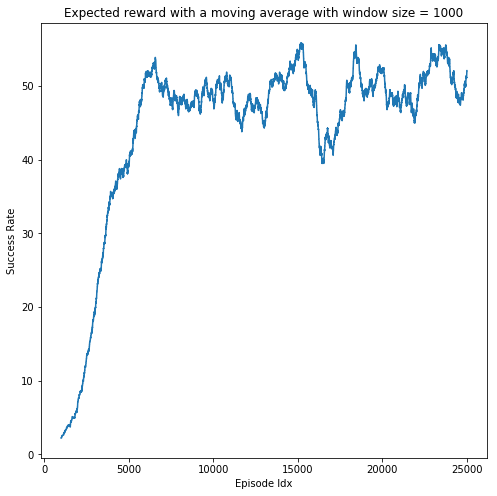

In [11]:
moving_avg_reward = []
window = 1000
for i in range(window, n):
    moving_avg_reward.append(100*sum(rewards[i-window:i])/window)

fig, axes = plt.subplots(figsize=(8, 8))
plt.plot(range(window, n), moving_avg_reward)
axes.set(xlabel='Episode Idx', ylabel='Success Rate', title='Expected reward with a moving average with window size = {}'.format(window))
plt.show()

We see that the agent has learned fairly well. From an initial probability of ~0.014 (via random walk), it now can reach the goal with a probability of 0.55 using the q_table decision

Let us check what the agents action would be at each state

In [12]:
# Print the action the agent takes at each state
env.reset()
env.render()
print(np.array([direction[x] for x in np.argmax(q_table, axis=1)]).reshape(4, 4))


SFFF
FHFH
FFFH
HFFG
[['LEFT ' 'UP   ' 'UP   ' 'UP   ']
 ['LEFT ' 'LEFT ' 'LEFT ' 'LEFT ']
 ['UP   ' 'DOWN ' 'LEFT ' 'LEFT ']
 ['LEFT ' 'RIGHT' 'DOWN ' 'LEFT ']]


### Trained Agent in Action
Now, let us use this trained agent to play Frozen Lake. Note that due to the slippery ice, the path taken each try would not be the same

In [13]:
n, max_steps = 10000, 100
count, num_prints = 0, 1
rewards = []
num_steps = []
for episode in range(n):
    s = env.reset()
    total_reward = 0
    if count<num_prints:
        print('---------EPISODE {}---------'.format(episode))
        env.render()
    for i in range(max_steps):
        a = np.argmax(q_table[s, :])
        s, r, done, info = env.step(a)
        total_reward+=r
        if count<num_prints:
            env.render()
        if done: 
            rewards.append(total_reward)
            num_steps.append(i+1)
            if count<num_prints: 
                if r==1:
                    print('SUCCESS!!!')
                else:
                    print('Failed :( )')
            count+=1
            break
env.close()
print('Success Percentage = {0:.2f} %'.format(100*np.sum(rewards)/len(rewards)))
print('Average number of steps taken to reach the goal = {0:.2f}'.format(np.mean(num_steps)))

---------EPISODE 0---------

SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
SUCCESS!!!
Success Percentage = 74.57 %
Average number of steps taken to reach the goal = 44.53



The agents success rate using this Q-Table is 74.6%! Notice that the average number of steps taken to reach the goal is very high. This is because, the agent takes many conservative steps (for example, moving UP eventhough there it is the boundary wall) to prevent slipping into the hole. 

## Agent using optimized non-slippery q-table

An intersting case to consider would be to assume that the ice werent slippery. In such a case, the agent would directly want to head to the goal. What would the success rate be, if we were to adopt that algorithm wherein the agent ignores the fact that the ice is slippery and blindly head towards the goal (of course, on the frozen ice and avoiding the hole). 

In [14]:
q_table_no_slip = np.array([[0, 1, 0, 0], 
                           [0, 0, 1, 0],
                           [0, 1, 0, 0],
                           [1, 0, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 0, 0],
                           [0, 0, 1, 0],
                           [0, 1, 0, 0],
                           [0, 1, 0, 0],
                           [0, 0, 0, 0],
                           [0, 0, 0, 0],
                           [0, 0, 1, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 0],])
# Print the action the agent takes at each state
env.reset()
env.render()
print(np.array([direction[x] for x in np.argmax(q_table_no_slip, axis=1)]).reshape(4, 4))


SFFF
FHFH
FFFH
HFFG
[['DOWN ' 'RIGHT' 'DOWN ' 'LEFT ']
 ['DOWN ' 'LEFT ' 'DOWN ' 'LEFT ']
 ['RIGHT' 'DOWN ' 'DOWN ' 'LEFT ']
 ['LEFT ' 'RIGHT' 'RIGHT' 'LEFT ']]


In [15]:
n, max_steps = 10000, 100
rewards = []
num_steps = []
for episode in range(n):
    s = env.reset()
    total_reward = 0
    for i in range(max_steps):
        a = np.argmax(q_table_no_slip[s, :])
        s, r, done, info = env.step(a)
        total_reward+=r
        if done: 
            rewards.append(total_reward)
            num_steps.append(i+1)
            break
env.close()
print('Success Percentage = {0:.2f} %'.format(100*np.sum(rewards)/len(rewards)))
print('Average number of steps taken to reach the goal = {0:.2f}'.format(np.mean(num_steps)))

Success Percentage = 4.11 %
Average number of steps taken to reach the goal = 5.03


We see that the success percentage using this q_table designed to take the optimal path if the ice werent slippery, has a very poor success rate. Also, we end up falling into the hole (or reaching the goal with a 4%) within an average of 5 steps! 

# Conclusions
In this report, we analyzed 3 potential algorithms that the agent can take to reach his goal. Clearly the path he takes 
* Random Walk
    * Success Rate = 1.4%
    * Average number of steps = 8
* Q-table trained on slippery condition: 
    * Success Rate = 75%
    * Average number of steps = 45
* Q-table trained on non-slippery condition:
    * Success Rate = 4%
    * Average number of steps = 5
